In [57]:
from scipy.integrate import odeint
import time
import math
import numpy as np
import pylab as py
from math import *
import numpy as np
from scipy.optimize import newton
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from IPython.display import HTML

import warnings

In [58]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def preprocess_sol(train_data_normalized, train_window):
    train_inout_seq= create_inout_sequences(train_data_normalized.reshape(751, nx), train_window)
    return train_inout_seq

In [59]:
# Parameters
L = 1  # Length of the domain
T = 1.5  # Total time
nx = 60  # Number of spatial points
nt = 751 # Number of time steps
alpha = 0.05  # Diffusion coefficient

dx = L / (nx - 1)
dt = T / nt

time = np.linspace(0, T, nt)

# Avoid that results converge to inifinity
if alpha * dt / dx**2 > 0.5:
    raise ValueError("Stability condition violated")

In [60]:
def numerical_solution(T, nt, nx, dt, dx, alpha):
    evo = []

    # Time-stepping loop
    for n in range(nt):
        T_new = T.copy()
        evo.append(T_new)
        for i in range(1, nx-1):
            T_new[i] = T[i] + (alpha * dt * (T[i+1] - 2*T[i] + T[i-1])) / dx**2
            
        # adiabatic Boundaries
        T_new[0] = T_new[1] # left border
        T_new[-1] = T_new[-2] # right border
        T = T_new

    diffusion_simulation = np.array(evo)
    
    return diffusion_simulation

In [61]:
# Initial condition: Gaussian distribution
x = np.linspace(0, L, nx)
length = L
# T = np.exp(-((x - length/2)**2) / (2 * (length/10)**2))+20

# T = np.linspace(30, 10, len(x))
T = 10 * np.sin(2 * np.pi * x / length) + 20


diffusion_simulation = numerical_solution(T, nt, nx, dt, dx, alpha)
last = np.average(diffusion_simulation[-1])
print(last)

19.999999999999996


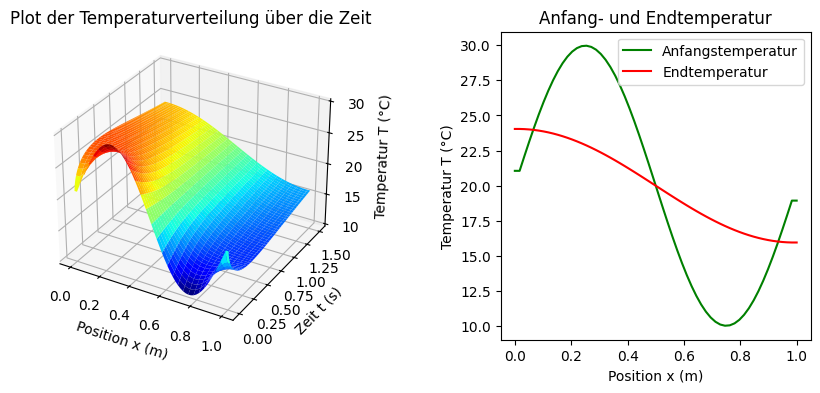

In [62]:
# Plotparms
t = time        
T = diffusion_simulation  

   
T = np.array(T).T
Initial_temp_dist = T[:, 0]
Final_temp_dist = T[:, -1]

# create figure
fig = plt.figure(figsize=(10, 4))



# 1. Subplot: 3D-Plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
# Erstelle ein Gitter aus Position (x) und Zeit (t)
X, T_grid = np.meshgrid(x, t)

# Transponiere die Temperaturmatrix für den Plot (da X und T_grid vertauscht sind)
Z = T.T

# Erstelle die 3D-Oberfläche
surf = ax.plot_surface(X, T_grid, Z, cmap='jet', edgecolor='none')
ax.set_title("Plot der Temperaturverteilung über die Zeit")
ax.set_xlabel("Position x (m)")
ax.set_ylabel("Zeit t (s)")
ax.set_zlabel("Temperatur T (°C)")
ax.grid(True)

# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Temperatur", location="left")

# 2. Subplot: 2D-Plot (Start- und Endzustand)
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(x, Initial_temp_dist, color='green', label="Anfangstemperatur")
ax2.plot(x, Final_temp_dist, color='red', label="Endtemperatur")
ax2.set_title("Anfang- und Endtemperatur")
ax2.set_xlabel("Position x (m)")
ax2.set_ylabel("Temperatur T (°C)")
ax2.legend()
plt.subplots_adjust(wspace=0.5)  # wspace steuert den horizontalen Abstand
# plt.subplots_adjust(hspace=0.3)
# Layout anpassen und anzeigen
# plt.tight_layout()
plt.show()

We will take to solutions.  the first is from the stable region and the second is chaotic

In [63]:
class MyLSTM(nn.Module):
    def __init__(self, num_layers, hidden_layer_size, nx):
        super().__init__()
        self.lstm = nn.LSTM(nx, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, nx)
        self.c_h = (torch.zeros(num_layers, 1, hidden_layer_size), torch.zeros(num_layers, 1, hidden_layer_size))

    def forward(self, x):
        h, self.c_h = self.lstm(x.view(len(x), 1, -1), self.c_h)
        predictions = self.linear(h.view(len(x), -1))
        return predictions[-1]

In [64]:
use_saved_model = True
hidden_layer_size = 100
num_layers = 1
model = MyLSTM(num_layers, hidden_layer_size, nx)
filename = 'datadriven_700epochs_sinus_diffusion'
if use_saved_model == True:
    model.load_state_dict(torch.load(filename))

else:
    torch.save(model.state_dict(), filename)

C:\Users\lauto\AppData\Local\Temp\ipykernel_15468\760197130.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


In [65]:
#this is the full OneStep function.   it
def OneStep(data, steps = 100):
    print('data set length =', len(data))
    train_window = 10
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(data.reshape(-1, nx))
    fut_pred = len(data) -train_window
    test_inputs = train_data_normalized[0:train_window].reshape(train_window,nx).tolist()
    #print(test_inputs)
    s2 = train_data_normalized.reshape(len(data),nx).tolist()
    realdata = data
    model.eval()
    preds = test_inputs.copy()
    t2 = test_inputs

    hidden_layer_size = 100
    x = 0
    for i in range(fut_pred):
        seq = torch.FloatTensor(t2[i:])
        model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                        torch.zeros(1, 1, hidden_layer_size))
        x = model(seq)
        preds.append(x.detach().numpy())
        t2.append(x.detach().numpy())
    actual_predictions = scaler.inverse_transform(np.array(preds ).reshape(-1,nx))

    pred_error = []
    mean_pred_error_of_line_list = []
    
    for i in range(len(data)):
        pred_error_line = []
        for j in range(len(data[i])):
            single_pred_error = np.abs(data[i][j] - actual_predictions[i][j])
            pred_error_line.append(single_pred_error)
        
        mean_error_line = np.mean(pred_error_line)
        mean_pred_error_of_line_list.append(mean_error_line)
        pred_error.append(pred_error_line)

    single_mean_error = np.mean(mean_pred_error_of_line_list)

    return actual_predictions, np.array(pred_error), single_mean_error

In [66]:
def save_to_csv(data, actual_predictions, pred_error, filename='output.csv'):
    
    df_true_data = pd.DataFrame(data)
    
    df_actual_predictions = pd.DataFrame(actual_predictions)
    
    df_pred_error = pd.DataFrame(pred_error)
    
    df_combined = pd.concat([df_true_data, df_actual_predictions, df_pred_error], axis=1)
    
    df_combined.to_csv(f'pred_and_error{filename}.csv', index=False)

In [ ]:
actual_predictions, absolute_pred_error, single_mean_error =OneStep(diffusion_simulation, steps=100)
save_to_csv(diffusion_simulation, actual_predictions, absolute_pred_error, filename)


data set length = 751


In [68]:
def heat_distribution_and_error_plotter(actual_predictions, absolute_pred_error, L, nx):
    # create figure
    fig = plt.figure(figsize=(12, 5))

    # 1. Subplo
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    # x, t grid for surface
    x = np.linspace(0, L, nx)
    X, T_grid = np.meshgrid(x, time)

    # shape change of Temperature
    Z = actual_predictions
    error_z = absolute_pred_error

    # Normiere den Fehler für die Farbgebung (0 bis 1)
    error_normalized = (error_z - np.min(error_z)) / (np.max(error_z) - np.min(error_z))

    # Define Colormap
    cmap = plt.colormaps['RdYlGn_r']

    # Create surface
    surf = ax.plot_surface(X, T_grid, Z, facecolors=cmap(error_normalized), edgecolor='none', shade=True)

    # In case you wanna plot the unscaled data
    # surf = ax.plot_surface(X, T_grid, Z, facecolors=cmap(absolute_pred_error), edgecolor='none', shade=True)

    # create scalarmapp for colorign the surface
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_array(absolute_pred_error)  
    mappable.set_clim(vmin=np.min(absolute_pred_error), vmax=np.max(absolute_pred_error))

    # add colorbar
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, location="left", label="Vorhersagefehler")

    ax.set_title("Temperaturverteilung über die Zeit mit Fehlerkennzeichnung")
    ax.set_xlabel("Position x (m)")
    ax.set_ylabel("Zeit t (s)")
    ax.set_zlabel("Temperatur T (°C)")

    # 2. Subplot: 2D-Plot
    ax2 = fig.add_subplot(1, 2, 2)
    Initial_temp_dist = actual_predictions[0]
    Final_temp_dist = actual_predictions[-1]

    ax2.plot(x, Initial_temp_dist, color='green', label="Anfangstemperatur")
    ax2.plot(x, Final_temp_dist, color='red', label="Endtemperatur")
    ax2.set_title("Anfangs- und Endtemperatur")
    ax2.set_xlabel("Position x (m)")
    ax2.set_ylabel("Temperatur T (°C)")
    ax2.legend()

    # increase distance between plots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

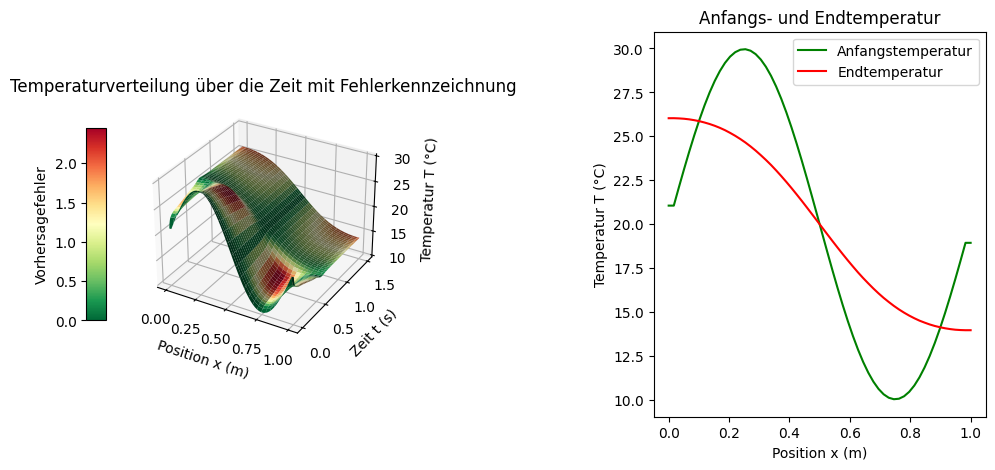

In [69]:
heat_distribution_and_error_plotter(actual_predictions, absolute_pred_error, L, nx)

In [70]:
def plot_temp_distribution(actual_predictions, L, nx):    
    # Parameter für den Plot
    x = np.linspace(0, L, nx)  # Position entlang der Strecke
    t = time        # Zeitpunkte aus der Lösung
    T = actual_predictions        # Temperaturwerte
    Initial_temp_dist = T[0]
    Final_temp_dist = T[-1]
    # Erstelle die Figur und die Achse
    fig = plt.figure(figsize=(10, 4))

    # 1. Subplot: 3D-Plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    # Erstelle ein Gitter aus Position (x) und Zeit (t)
    X, T_grid = np.meshgrid(x, t)

    # Transponiere die Temperaturmatrix für den Plot (da X und T_grid vertauscht sind)
    Z = T

    # Erstelle die 3D-Oberfläche
    surf = ax.plot_surface(X, T_grid, Z, cmap='jet', edgecolor='none')
    ax.set_title("Plot der Temperaturverteilung über die Zeit")
    ax.set_xlabel("Position x (m)")
    ax.set_ylabel("Zeit t (s)")
    ax.set_zlabel("Temperatur T (°C)")
    # fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Temperatur")

    # 2. Subplot: 2D-Plot (Start- und Endzustand)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(x, Initial_temp_dist, color='green', label="Anfangstemperatur")
    ax2.plot(x, Final_temp_dist, color='red', label="Endtemperatur")
    ax2.set_title("Anfangs- und Endtemperatur")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.legend()

    plt.subplots_adjust(wspace=0.5)

    # Layout anpassen und anzeigen
    plt.tight_layout()
    plt.show()

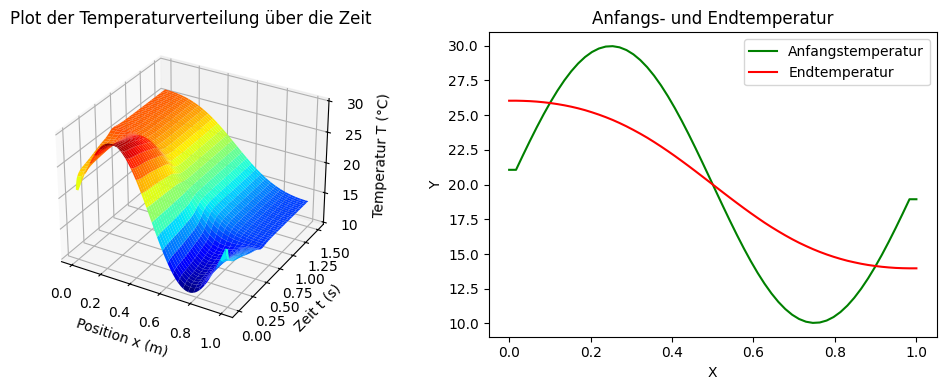

In [71]:
plot_temp_distribution(actual_predictions, L, nx)